# The competition

**Objective:**

The objective of the M5 forecasting competition is to advance the theory and practice of forecasting by identifying the method(s) that provide the most accurate point forecasts for each of the 42,840 time series of the competition.

To that end, the participants of M5 are asked to provide 28 days ahead point forecasts (PFs) for all the series of the competition, as well as the corresponding median and 50%, 67%, 95%, and 99% prediction intervals (PIs).

**Available data:**
* more than 5 years of sales data spread over 3 states (TX, CA, WI), 10 Walmart stores for 3049 items in three categories (household, foods, hobbies)
* Data is given in three separate files:
    * calendar: containing the details of the dates, associated events
    * sales data: daily sales data of how much each item was sold where
    * selling prices: weekly selling price list for a given item

**What do we want to do to start?**
* Take a single store (CA_1) and perform the analysis to understand the process, data manipulation, etc.


# Preambles: Data, Module loading and manipulation

We assume that the data has been downloaded from the competition website: https://www.kaggle.com/c/m5-forecasting-accuracy

and are available in the local folder.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

In [2]:
cal_df = pd.read_csv('calendar.csv')

In [3]:
sales_df = pd.read_csv('sales_train_evaluation.csv')

In [4]:
sellprices_df = pd.read_csv('sell_prices.csv')

In [5]:
sales_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [6]:
sellprices_df.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


# Analysing calendar

Calendar contains the temporal and cultural/social information available. We will trim it down to what is required for the analysis that focuses on CA_1

In [7]:
cal_df.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


Some comments:
* The `wm_yr_wk` would be useful to correlate with the weekly sellprice data
* The `weekday` column is irrelevant as `wday` provides the same information. We just need to know the mapping that a weekday starts on a Saturday
* `month` and `year` information shall become irrelevant if `date` column in appropriately transformed to `datetime` format.
* `snap_XX` corresponds to the days were low-income households can avail some benefits
* The four events column correspond effectively to mark the cultural/social events. In a way, we can reduce this all to whether an event happened that day or not. 
    * However, in future, specific events may actually need more emphasis as there would be flurry of purchse of HOBBIES items before an event to be gifted to friends.
    * One other approach could be to classify an event based on whether we have to analyse past days or not. 
    * Some events such as a game night might lead to more food bought whereas others might lead to people not turning up (e.g. Christmas)

In [8]:
cal_df['event_name_1'].unique()

array([nan, 'SuperBowl', 'ValentinesDay', 'PresidentsDay', 'LentStart',
       'LentWeek2', 'StPatricksDay', 'Purim End', 'OrthodoxEaster',
       'Pesach End', 'Cinco De Mayo', "Mother's day", 'MemorialDay',
       'NBAFinalsStart', 'NBAFinalsEnd', "Father's day",
       'IndependenceDay', 'Ramadan starts', 'Eid al-Fitr', 'LaborDay',
       'ColumbusDay', 'Halloween', 'EidAlAdha', 'VeteransDay',
       'Thanksgiving', 'Christmas', 'Chanukah End', 'NewYear',
       'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter'], dtype=object)

In [9]:
cal_df['event_name_2'].unique()

array([nan, 'Easter', 'Cinco De Mayo', 'OrthodoxEaster', "Father's day"],
      dtype=object)

In [10]:
 cal_df[(cal_df['event_name_1'].isna()==False) | (cal_df['event_name_2'].isna()==False)]

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1,1,1
16,2011-02-14,11103,Monday,3,2,2011,d_17,ValentinesDay,Cultural,NaN,NaN,0,0,1
23,2011-02-21,11104,Monday,3,2,2011,d_24,PresidentsDay,National,NaN,NaN,0,0,0
39,2011-03-09,11106,Wednesday,5,3,2011,d_40,LentStart,Religious,NaN,NaN,1,1,1
46,2011-03-16,11107,Wednesday,5,3,2011,d_47,LentWeek2,Religious,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1926,2016-05-08,11615,Sunday,2,5,2016,d_1927,Mother's day,Cultural,NaN,NaN,1,0,1
1948,2016-05-30,11618,Monday,3,5,2016,d_1949,MemorialDay,National,NaN,NaN,0,0,0
1951,2016-06-02,11618,Thursday,6,6,2016,d_1952,NBAFinalsStart,Sporting,NaN,NaN,1,0,1
1956,2016-06-07,11619,Tuesday,4,6,2016,d_1957,Ramadan starts,Religious,NaN,NaN,1,1,0


In [11]:
# This function would aggretate all the events into a single 1/0 column
def event_encoding(x):
    try:
        if (np.isnan(x['event_name_1'])==False) or (np.isnan(x['event_name_2'])==False):
            return 1
        else:
            return 0
    except:
        return 1

Applying the above function to the event names columns

In [12]:
cal_df['Events'] = cal_df[['event_name_1', 'event_name_2']].apply(event_encoding, axis=1)

In [13]:
cal_df['event_type_1'].unique()

array([nan, 'Sporting', 'Cultural', 'National', 'Religious'], dtype=object)

In [14]:
cal_df['event_type_2'].unique()

array([nan, 'Cultural', 'Religious'], dtype=object)

The events have broadly four categories. So we will classify them as follows:
* 0 - NAN
* 1 - Cultural
* 2 - Religious
* 3 - Sporting
* 4 - National

If an event is a mix of the two, then we will make the following choice
e.g.
* Cultural+Religious - 12 (or 21)
* Religious+Sporting - 32 (or 23)

**The above remains in the idea state and has not been implemented**

In [15]:
cal_df_CA_1 = cal_df.copy()

In [16]:
cal_df_CA_1.drop(columns=['event_name_1', 'event_name_2', 'snap_TX', 'snap_WI', 'weekday', 'event_type_2', 'event_type_1', 'month', 'year'], inplace=True)

In [17]:
cal_df_CA_1.head()

,date,wm_yr_wk,wday,d,snap_CA,Events
0,2011-01-29,11101,1,d_1,0,0
1,2011-01-30,11101,2,d_2,0,0
2,2011-01-31,11101,3,d_3,0,0
3,2011-02-01,11101,4,d_4,1,0
4,2011-02-02,11101,5,d_5,1,0


In [18]:
import datetime as dt

In [19]:
def encode_date_time(x):
    date = str.split(x,'-')
    return dt.datetime(int(date[0]), int(date[1]), int(date[2]))

In [20]:
cal_df_CA_1['dt'] = cal_df_CA_1['date'].apply(encode_date_time)

In [21]:
cal_df_CA_1.drop(columns='date',inplace=True)

In [22]:
cal_df_CA_1.head()

,wm_yr_wk,wday,d,snap_CA,Events,dt
0,11101,1,d_1,0,0,2011-01-29
1,11101,2,d_2,0,0,2011-01-30
2,11101,3,d_3,0,0,2011-01-31
3,11101,4,d_4,1,0,2011-02-01
4,11101,5,d_5,1,0,2011-02-02


Renaming the day numbers from d_1, d_2, ... to 1, 2,... to make it easier to do any numerical analysis required. This change should also be done on the sales data

In [23]:
def rename_day(x):
    return(int(str.split(x, '_')[1]))

In [24]:
cal_df_CA_1['day'] = cal_df_CA_1['d'].apply(rename_day)

In [25]:
cal_df_CA_1.drop(columns='d',inplace=True)

In [26]:
cal_df_CA_1.head()

,wm_yr_wk,wday,snap_CA,Events,dt,day
0,11101,1,0,0,2011-01-29,1
1,11101,2,0,0,2011-01-30,2
2,11101,3,0,0,2011-01-31,3
3,11101,4,1,0,2011-02-01,4
4,11101,5,1,0,2011-02-02,5


The training data given for sales is restricted to 1941 days whereas the calendar runs for the entire 1969 days. So we would remove those parts

In [27]:
cal_df_CA_1 = cal_df_CA_1[:-28]

# Analysing Sales data

In [28]:
sales_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


As a first step, we will focus only on the `CA_1` data. This means, we can also drop the state_id

In [29]:
sales_df_CA_1 = sales_df[sales_df['store_id']=='CA_1']

In [30]:
sales_df_CA_1.drop(columns=['state_id', 'store_id'])

,id,item_id,dept_id,cat_id,d_1,d_2,d_3,d_4,d_5,d_6,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,0,0,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,0,0,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,0,0,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,0,0,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,0,0,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3044,FOODS_3_823_CA_1_evaluation,FOODS_3_823,FOODS_3,FOODS,0,0,0,0,0,0,...,3,0,3,1,0,2,4,3,4,2
3045,FOODS_3_824_CA_1_evaluation,FOODS_3_824,FOODS_3,FOODS,1,0,5,0,0,3,...,0,0,0,1,2,0,3,0,0,0
3046,FOODS_3_825_CA_1_evaluation,FOODS_3_825,FOODS_3,FOODS,0,0,0,0,0,0,...,0,0,0,2,0,2,0,3,0,1
3047,FOODS_3_826_CA_1_evaluation,FOODS_3_826,FOODS_3,FOODS,0,0,0,0,0,0,...,0,1,2,1,3,3,0,1,2,1


The id also seems not relevant.

In [31]:
sales_df_CA_1.drop(columns=['state_id', 'store_id', 'id'], inplace=True)

/home/krishnan/.local/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [32]:
sales_df_CA_1.head()

,item_id,dept_id,cat_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,0,0,0,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,0,0,0,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,0,0,0,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,0,0,0,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,0,0,0,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


Since we have the different IDs seem to portray the same thing, we can do the following encoding:
```
ID = 0
cat_id = 1,2,3 * 100000
ID = ID+cat_id
dept_id = the last digit * 10000
ID += dept_id
item_id = the last digit * 1000
ID += item_id
```

This would make the entire three columns into a single numerical column

In [33]:
cat_id_dummies = pd.get_dummies(sales_df_CA_1.cat_id)

In [34]:
sales_df_CA_1['cat_id'] = pd.Categorical(sales_df_CA_1.cat_id)

<ipython-input-34-4fa206934171>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_df_CA_1['cat_id'] = pd.Categorical(sales_df_CA_1.cat_id)


In [35]:
sales_df_CA_1

,item_id,dept_id,cat_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,0,0,0,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,0,0,0,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,0,0,0,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,0,0,0,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,0,0,0,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3044,FOODS_3_823,FOODS_3,FOODS,0,0,0,0,0,0,0,...,3,0,3,1,0,2,4,3,4,2
3045,FOODS_3_824,FOODS_3,FOODS,1,0,5,0,0,3,0,...,0,0,0,1,2,0,3,0,0,0
3046,FOODS_3_825,FOODS_3,FOODS,0,0,0,0,0,0,0,...,0,0,0,2,0,2,0,3,0,1
3047,FOODS_3_826,FOODS_3,FOODS,0,0,0,0,0,0,0,...,0,1,2,1,3,3,0,1,2,1


In [36]:
sales_df_CA_1.cat_id.cat.codes

0       1
1       1
2       1
3       1
4       1
       ..
3044    0
3045    0
3046    0
3047    0
3048    0
Length: 3049, dtype: int8

The encoding is as follows:
* 1 - HOBBIES
* 2 - HOUSEHOLDS
* 0 - FOODS

In [37]:
sales_df_CA_1.dept_id.unique()

array(['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1',
       'FOODS_2', 'FOODS_3'], dtype=object)

In [38]:
def encode_dept_id(x):
    return int(str.split(x,'_')[1])

In [39]:
sales_df_CA_1.dept_id.apply(encode_dept_id)

0       1
1       1
2       1
3       1
4       1
       ..
3044    3
3045    3
3046    3
3047    3
3048    3
Name: dept_id, Length: 3049, dtype: int64

In [40]:
def encode_item_id(x):
    return(int(str.split(x,'_')[-1]))

In [41]:
sales_df_CA_1.item_id.apply(encode_item_id)

0         1
1         2
2         3
3         4
4         5
       ... 
3044    823
3045    824
3046    825
3047    826
3048    827
Name: item_id, Length: 3049, dtype: int64

In [42]:
temp_df = pd.DataFrame([])

In [43]:
temp_df['item_id'] = sales_df_CA_1.item_id.apply(encode_item_id)

In [44]:
temp_df['dept_id'] = sales_df_CA_1.dept_id.apply(encode_dept_id)

In [45]:
temp_df['cat_id'] = sales_df_CA_1.cat_id.cat.codes

In [46]:
temp_df.head()

,item_id,dept_id,cat_id
0,1,1,1
1,2,1,1
2,3,1,1
3,4,1,1
4,5,1,1


In [47]:
max(temp_df['item_id'])

827

Since we have a max here of a 3-digit number, we can consider mapping the three together into a single number

In [48]:
temp_df['unique_id'] = temp_df['cat_id']*10000 + temp_df['dept_id']*1000 + temp_df['item_id']

In [49]:
temp_df.head()

,item_id,dept_id,cat_id,unique_id
0,1,1,1,11001
1,2,1,1,11002
2,3,1,1,11003
3,4,1,1,11004
4,5,1,1,11005


In [50]:
(temp_df['unique_id'] - (temp_df['unique_id']//10000)*10000)//1000

0       1
1       1
2       1
3       1
4       1
       ..
3044    3
3045    3
3046    3
3047    3
3048    3
Name: unique_id, Length: 3049, dtype: int64

**Warning: None of the temp_df exploration has been integrated. We only have the categorical values of the items integrated**


In [51]:
def get_item_dept_cat(x):
    item = x//10000
    dept = (x-(item*10000))//1000
    cat = x%(10000+dept*1000)
    return item, dept, cat

In [52]:
print(temp_df.iloc[1258])
get_item_dept_cat(temp_df['unique_id'].iloc[1258])

item_id        162
dept_id          2
cat_id           2
unique_id    22162
Name: 1258, dtype: int64


(2, 2, 10162)

# Analysing Selling data

In [53]:
sellprices_df.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [54]:
sellprices_df_CA_1 = sellprices_df[sellprices_df['store_id']=='CA_1']

In [55]:
sellprices_df_CA_1.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [56]:
sellprices_df_CA_1.drop(columns='store_id', inplace=True)

/home/krishnan/.local/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [57]:
sellprices_df_CA_1.head()

,item_id,wm_yr_wk,sell_price
0,HOBBIES_1_001,11325,9.58
1,HOBBIES_1_001,11326,9.58
2,HOBBIES_1_001,11327,8.26
3,HOBBIES_1_001,11328,8.26
4,HOBBIES_1_001,11329,8.26


In [58]:
sellprices_df_CA_1['wm_yr_wk'].nunique()

282

In [59]:
cal_df_CA_1['wm_yr_wk'].nunique()

278

To focus on the training data alone, we will have to consider same number of sellprices data as the sales data is available. This means we will have to leave out the last 4 weeks of data.

In [60]:
cal_df_CA_1['wm_yr_wk'].iloc[-1]

11617

In [61]:
max(sellprices_df_CA_1['wm_yr_wk'].unique())

11621

We need to remove all entries above 11617. However, the presence of this week does not necessarily bother us because we would never have to deal with them unless we would fuse the two data together. While fusing, this would be automatically left out.

In [62]:
cal_df_CA_1['wm_yr_wk'].unique()

array([11101, 11102, 11103, 11104, 11105, 11106, 11107, 11108, 11109,
       11110, 11111, 11112, 11113, 11114, 11115, 11116, 11117, 11118,
       11119, 11120, 11121, 11122, 11123, 11124, 11125, 11126, 11127,
       11128, 11129, 11130, 11131, 11132, 11133, 11134, 11135, 11136,
       11137, 11138, 11139, 11140, 11141, 11142, 11143, 11144, 11145,
       11146, 11147, 11148, 11149, 11150, 11151, 11152, 11201, 11202,
       11203, 11204, 11205, 11206, 11207, 11208, 11209, 11210, 11211,
       11212, 11213, 11214, 11215, 11216, 11217, 11218, 11219, 11220,
       11221, 11222, 11223, 11224, 11225, 11226, 11227, 11228, 11229,
       11230, 11231, 11232, 11233, 11234, 11235, 11236, 11237, 11238,
       11239, 11240, 11241, 11242, 11243, 11244, 11245, 11246, 11247,
       11248, 11249, 11250, 11251, 11252, 11301, 11302, 11303, 11304,
       11305, 11306, 11307, 11308, 11309, 11310, 11311, 11312, 11313,
       11314, 11315, 11316, 11317, 11318, 11319, 11320, 11321, 11322,
       11323, 11324,

# Combining the datasets

In [63]:
cal_df_CA_1.head()

,wm_yr_wk,wday,snap_CA,Events,dt,day
0,11101,1,0,0,2011-01-29,1
1,11101,2,0,0,2011-01-30,2
2,11101,3,0,0,2011-01-31,3
3,11101,4,1,0,2011-02-01,4
4,11101,5,1,0,2011-02-02,5


In [64]:
sellprices_df_CA_1.head()

,item_id,wm_yr_wk,sell_price
0,HOBBIES_1_001,11325,9.58
1,HOBBIES_1_001,11326,9.58
2,HOBBIES_1_001,11327,8.26
3,HOBBIES_1_001,11328,8.26
4,HOBBIES_1_001,11329,8.26


In [65]:
sales_df_CA_1.head()

,item_id,dept_id,cat_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,0,0,0,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,0,0,0,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,0,0,0,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,0,0,0,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,0,0,0,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [66]:
sellprices_cal_df_CA_1 = sellprices_df_CA_1.copy()

In [67]:
sellprices_cal_df_CA_1 = sellprices_cal_df_CA_1[sellprices_cal_df_CA_1['wm_yr_wk'] < 11618]

In [68]:
sellprices_cal_df_CA_1.set_index('wm_yr_wk', inplace=True)

In [69]:
sellprices_cal_df_CA_1

,item_id,sell_price
wm_yr_wk,,
11325,HOBBIES_1_001,9.58
11326,HOBBIES_1_001,9.58
11327,HOBBIES_1_001,8.26
11328,HOBBIES_1_001,8.26
11329,HOBBIES_1_001,8.26
...,...,...
11613,FOODS_3_827,1.00
11614,FOODS_3_827,1.00
11615,FOODS_3_827,1.00


In [70]:
sellprices_cal_df_CA_1.join(cal_df_CA_1.set_index('wm_yr_wk'), on='wm_yr_wk')

,item_id,sell_price,wday,snap_CA,Events,dt,day
wm_yr_wk,,,,,,,
11325,HOBBIES_1_001,9.58,1,0,0,2013-07-13,897
11325,HOBBIES_1_001,9.58,2,0,0,2013-07-14,898
11325,HOBBIES_1_001,9.58,3,0,0,2013-07-15,899
11325,HOBBIES_1_001,9.58,4,0,0,2013-07-16,900
11325,HOBBIES_1_001,9.58,5,0,0,2013-07-17,901
...,...,...,...,...,...,...,...
11616,FOODS_3_827,1.00,5,0,0,2016-05-18,1937
11616,FOODS_3_827,1.00,6,0,0,2016-05-19,1938
11616,FOODS_3_827,1.00,7,0,0,2016-05-20,1939


In [71]:
sellprices_cal_df_CA_1

,item_id,sell_price
wm_yr_wk,,
11325,HOBBIES_1_001,9.58
11326,HOBBIES_1_001,9.58
11327,HOBBIES_1_001,8.26
11328,HOBBIES_1_001,8.26
11329,HOBBIES_1_001,8.26
...,...,...
11613,FOODS_3_827,1.00
11614,FOODS_3_827,1.00
11615,FOODS_3_827,1.00


 What next?
 
 How to use pivot tables to combine these? We need to have the selling price and sales price combined

<hr>
Update: 07 January 2021

In [72]:
def change_day_name(x):
    return 'd_'+str(x)

In [73]:
sellprices_cal_df_CA_1 = sellprices_cal_df_CA_1.join(cal_df_CA_1.set_index('wm_yr_wk'), on='wm_yr_wk')

In [74]:
sellprices_cal_df_CA_1

,item_id,sell_price,wday,snap_CA,Events,dt,day
wm_yr_wk,,,,,,,
11325,HOBBIES_1_001,9.58,1,0,0,2013-07-13,897
11325,HOBBIES_1_001,9.58,2,0,0,2013-07-14,898
11325,HOBBIES_1_001,9.58,3,0,0,2013-07-15,899
11325,HOBBIES_1_001,9.58,4,0,0,2013-07-16,900
11325,HOBBIES_1_001,9.58,5,0,0,2013-07-17,901
...,...,...,...,...,...,...,...
11616,FOODS_3_827,1.00,5,0,0,2016-05-18,1937
11616,FOODS_3_827,1.00,6,0,0,2016-05-19,1938
11616,FOODS_3_827,1.00,7,0,0,2016-05-20,1939


In [75]:
sellprices_cal_df_CA_1['day'] = sellprices_cal_df_CA_1['day'].apply(change_day_name)

In [76]:
sellprices_cal_df_CA_1.head()

,item_id,sell_price,wday,snap_CA,Events,dt,day
wm_yr_wk,,,,,,,
11325,HOBBIES_1_001,9.58,1,0,0,2013-07-13,d_897
11325,HOBBIES_1_001,9.58,2,0,0,2013-07-14,d_898
11325,HOBBIES_1_001,9.58,3,0,0,2013-07-15,d_899
11325,HOBBIES_1_001,9.58,4,0,0,2013-07-16,d_900
11325,HOBBIES_1_001,9.58,5,0,0,2013-07-17,d_901


In [77]:
pd.pivot_table(sellprices_cal_df_CA_1, values='sell_price', index='item_id', columns='day')

day,d_1,d_10,d_100,d_1000,d_1001,d_1002,d_1003,d_1004,d_1005,d_1006,...,d_990,d_991,d_992,d_993,d_994,d_995,d_996,d_997,d_998,d_999
item_id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001,2.00,2.00,2.00,2.24,2.24,2.24,2.24,2.24,2.24,2.24,...,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24
FOODS_1_002,7.88,7.88,7.88,8.88,8.88,8.88,8.88,8.88,8.88,8.88,...,8.88,8.88,8.88,8.88,8.88,8.88,8.88,8.88,8.88,8.88
FOODS_1_003,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,...,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88
FOODS_1_004,NaN,NaN,NaN,1.78,1.78,1.78,1.78,1.78,1.78,1.78,...,1.78,1.78,1.78,1.78,1.78,1.78,1.78,1.78,1.78,1.78
FOODS_1_005,2.94,2.94,2.94,3.28,3.28,3.28,3.28,3.28,3.28,3.28,...,3.28,3.28,3.28,3.28,3.28,3.28,3.28,3.28,3.28,3.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOUSEHOLD_2_512,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,...,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97
HOUSEHOLD_2_513,NaN,NaN,NaN,2.78,2.78,2.78,2.78,2.78,2.78,2.78,...,2.78,2.78,2.78,2.78,2.78,2.78,2.78,2.78,2.78,2.78
HOUSEHOLD_2_514,18.97,18.97,18.97,17.94,17.94,17.94,17.94,17.94,17.94,17.94,...,17.94,17.94,17.94,17.94,17.94,17.94,17.94,17.94,17.94,17.94


In [78]:
sales_df_CA_1

,item_id,dept_id,cat_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,0,0,0,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,0,0,0,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,0,0,0,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,0,0,0,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,0,0,0,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3044,FOODS_3_823,FOODS_3,FOODS,0,0,0,0,0,0,0,...,3,0,3,1,0,2,4,3,4,2
3045,FOODS_3_824,FOODS_3,FOODS,1,0,5,0,0,3,0,...,0,0,0,1,2,0,3,0,0,0
3046,FOODS_3_825,FOODS_3,FOODS,0,0,0,0,0,0,0,...,0,0,0,2,0,2,0,3,0,1
3047,FOODS_3_826,FOODS_3,FOODS,0,0,0,0,0,0,0,...,0,1,2,1,3,3,0,1,2,1


 Undoing the renaming of 'day' column

In [79]:
sellprices_cal_df_CA_1 = sellprices_df_CA_1.copy()
sellprices_cal_df_CA_1 = sellprices_cal_df_CA_1[sellprices_cal_df_CA_1['wm_yr_wk'] < 11618]
sellprices_cal_df_CA_1.set_index('wm_yr_wk', inplace=True)
sellprices_cal_df_CA_1 = sellprices_cal_df_CA_1.join(cal_df_CA_1.set_index('wm_yr_wk'), on='wm_yr_wk')

In [80]:
sellprices_cal_df_CA_1

,item_id,sell_price,wday,snap_CA,Events,dt,day
wm_yr_wk,,,,,,,
11325,HOBBIES_1_001,9.58,1,0,0,2013-07-13,897
11325,HOBBIES_1_001,9.58,2,0,0,2013-07-14,898
11325,HOBBIES_1_001,9.58,3,0,0,2013-07-15,899
11325,HOBBIES_1_001,9.58,4,0,0,2013-07-16,900
11325,HOBBIES_1_001,9.58,5,0,0,2013-07-17,901
...,...,...,...,...,...,...,...
11616,FOODS_3_827,1.00,5,0,0,2016-05-18,1937
11616,FOODS_3_827,1.00,6,0,0,2016-05-19,1938
11616,FOODS_3_827,1.00,7,0,0,2016-05-20,1939


In [81]:
pd.pivot_table(sellprices_cal_df_CA_1, values='sell_price', index='item_id', columns='day')

day,1,2,3,4,5,6,7,8,9,10,...,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941
item_id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,...,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24
FOODS_1_002,7.88,7.88,7.88,7.88,7.88,7.88,7.88,7.88,7.88,7.88,...,9.48,9.48,9.48,9.48,9.48,9.48,9.48,9.48,9.48,9.48
FOODS_1_003,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,...,3.23,3.23,3.23,3.23,3.23,3.23,3.23,3.23,3.23,3.23
FOODS_1_004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96
FOODS_1_005,2.94,2.94,2.94,2.94,2.94,2.94,2.94,2.94,2.94,2.94,...,3.54,3.54,3.54,3.54,3.54,3.54,3.54,3.54,3.54,3.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOUSEHOLD_2_512,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,...,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97
HOUSEHOLD_2_513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.78,2.78,2.78,2.78,2.78,2.78,2.78,2.78,2.78,2.78
HOUSEHOLD_2_514,18.97,18.97,18.97,18.97,18.97,18.97,18.97,18.97,18.97,18.97,...,19.54,19.54,19.54,19.54,19.54,19.54,19.54,19.54,19.54,19.54


In [82]:
pivot_selling_cal_CA_1 = pd.pivot_table(sellprices_cal_df_CA_1, values='sell_price', index='item_id', columns='day')

In [83]:
dict_col_name = {}
for i in range(1,1942):
    dict_col_name[i] = 'd_'+str(i)

In [84]:
pivot_selling_cal_CA_1.rename(columns=dict_col_name, inplace=True)

In [85]:
pivot_selling_cal_CA_1

day,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,...,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24
FOODS_1_002,7.88,7.88,7.88,7.88,7.88,7.88,7.88,7.88,7.88,7.88,...,9.48,9.48,9.48,9.48,9.48,9.48,9.48,9.48,9.48,9.48
FOODS_1_003,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,...,3.23,3.23,3.23,3.23,3.23,3.23,3.23,3.23,3.23,3.23
FOODS_1_004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96
FOODS_1_005,2.94,2.94,2.94,2.94,2.94,2.94,2.94,2.94,2.94,2.94,...,3.54,3.54,3.54,3.54,3.54,3.54,3.54,3.54,3.54,3.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOUSEHOLD_2_512,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,...,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97
HOUSEHOLD_2_513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.78,2.78,2.78,2.78,2.78,2.78,2.78,2.78,2.78,2.78
HOUSEHOLD_2_514,18.97,18.97,18.97,18.97,18.97,18.97,18.97,18.97,18.97,18.97,...,19.54,19.54,19.54,19.54,19.54,19.54,19.54,19.54,19.54,19.54


In [86]:
sales_df_CA_1

,item_id,dept_id,cat_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,0,0,0,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,0,0,0,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,0,0,0,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,0,0,0,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,0,0,0,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3044,FOODS_3_823,FOODS_3,FOODS,0,0,0,0,0,0,0,...,3,0,3,1,0,2,4,3,4,2
3045,FOODS_3_824,FOODS_3,FOODS,1,0,5,0,0,3,0,...,0,0,0,1,2,0,3,0,0,0
3046,FOODS_3_825,FOODS_3,FOODS,0,0,0,0,0,0,0,...,0,0,0,2,0,2,0,3,0,1
3047,FOODS_3_826,FOODS_3,FOODS,0,0,0,0,0,0,0,...,0,1,2,1,3,3,0,1,2,1


In [87]:
sales_df_CA_1.set_index(keys='item_id', inplace=True)

In [88]:
sales_df_CA_1.drop(columns=['dept_id', 'cat_id'], inplace=True)

/home/krishnan/.local/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [89]:
sales_df_CA_1

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001,0,0,0,0,0,0,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
HOBBIES_1_002,0,0,0,0,0,0,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
HOBBIES_1_003,0,0,0,0,0,0,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
HOBBIES_1_004,0,0,0,0,0,0,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
HOBBIES_1_005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FOODS_3_823,0,0,0,0,0,0,0,0,0,0,...,3,0,3,1,0,2,4,3,4,2
FOODS_3_824,1,0,5,0,0,3,0,0,2,1,...,0,0,0,1,2,0,3,0,0,0
FOODS_3_825,0,0,0,0,0,0,0,1,2,1,...,0,0,0,2,0,2,0,3,0,1


In [90]:
pivot_selling_cal_CA_1.fillna(0, inplace=True)

In [91]:
sales_df_CA_1.sort_index(inplace=True)

<ipython-input-91-fca79d173c68>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_df_CA_1.sort_index(inplace=True)


In [92]:
sales_df_CA_1

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001,3,0,0,1,4,2,0,2,0,0,...,2,3,1,0,0,0,1,0,0,0
FOODS_1_002,0,1,0,1,1,1,0,0,0,0,...,2,1,0,1,1,1,0,1,1,2
FOODS_1_003,0,0,0,0,1,3,1,1,1,0,...,2,0,0,0,0,0,2,2,0,1
FOODS_1_004,0,0,0,0,0,0,0,0,0,0,...,5,6,2,5,1,2,1,1,3,4
FOODS_1_005,3,9,3,3,0,2,1,2,1,7,...,2,1,11,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOUSEHOLD_2_512,0,0,0,0,0,2,1,1,2,0,...,1,1,1,0,0,0,2,2,0,0
HOUSEHOLD_2_513,0,0,0,0,0,0,0,0,0,0,...,0,0,2,1,0,1,0,1,0,0
HOUSEHOLD_2_514,2,1,1,0,1,0,1,0,0,0,...,2,0,1,0,0,0,1,0,0,0


In [93]:
pivot_selling_cal_CA_1

day,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,...,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24
FOODS_1_002,7.88,7.88,7.88,7.88,7.88,7.88,7.88,7.88,7.88,7.88,...,9.48,9.48,9.48,9.48,9.48,9.48,9.48,9.48,9.48,9.48
FOODS_1_003,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,...,3.23,3.23,3.23,3.23,3.23,3.23,3.23,3.23,3.23,3.23
FOODS_1_004,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96
FOODS_1_005,2.94,2.94,2.94,2.94,2.94,2.94,2.94,2.94,2.94,2.94,...,3.54,3.54,3.54,3.54,3.54,3.54,3.54,3.54,3.54,3.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOUSEHOLD_2_512,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,...,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97
HOUSEHOLD_2_513,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,2.78,2.78,2.78,2.78,2.78,2.78,2.78,2.78,2.78,2.78
HOUSEHOLD_2_514,18.97,18.97,18.97,18.97,18.97,18.97,18.97,18.97,18.97,18.97,...,19.54,19.54,19.54,19.54,19.54,19.54,19.54,19.54,19.54,19.54


In [94]:
revenue_CA_1 = pivot_selling_cal_CA_1.multiply(sales_df_CA_1)

In [95]:
revenue_CA_1

day,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001,6.00,0.00,0.00,2.00,8.00,4.00,0.00,4.00,0.00,0.00,...,4.48,6.72,2.24,0.00,0.00,0.00,2.24,0.00,0.00,0.00
FOODS_1_002,0.00,7.88,0.00,7.88,7.88,7.88,0.00,0.00,0.00,0.00,...,18.96,9.48,0.00,9.48,9.48,9.48,0.00,9.48,9.48,18.96
FOODS_1_003,0.00,0.00,0.00,0.00,2.88,8.64,2.88,2.88,2.88,0.00,...,6.46,0.00,0.00,0.00,0.00,0.00,6.46,6.46,0.00,3.23
FOODS_1_004,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,9.80,11.76,3.92,9.80,1.96,3.92,1.96,1.96,5.88,7.84
FOODS_1_005,8.82,26.46,8.82,8.82,0.00,5.88,2.94,5.88,2.94,20.58,...,7.08,3.54,38.94,0.00,0.00,0.00,0.00,0.00,0.00,3.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOUSEHOLD_2_512,0.00,0.00,0.00,0.00,0.00,7.94,3.97,3.97,7.94,0.00,...,3.97,3.97,3.97,0.00,0.00,0.00,7.94,7.94,0.00,0.00
HOUSEHOLD_2_513,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,5.56,2.78,0.00,2.78,0.00,2.78,0.00,0.00
HOUSEHOLD_2_514,37.94,18.97,18.97,0.00,18.97,0.00,18.97,0.00,0.00,0.00,...,39.08,0.00,19.54,0.00,0.00,0.00,19.54,0.00,0.00,0.00


**Change Log**

Update: 14 Jan 2021

In [96]:
pivot_selling_cal_CA_1 == 0

day,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
FOODS_1_002,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
FOODS_1_003,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
FOODS_1_004,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
FOODS_1_005,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOUSEHOLD_2_512,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
HOUSEHOLD_2_513,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
HOUSEHOLD_2_514,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [97]:
sales_df_CA_1 == 0

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001,False,True,True,False,False,False,True,False,True,True,...,False,False,False,True,True,True,False,True,True,True
FOODS_1_002,True,False,True,False,False,False,True,True,True,True,...,False,False,True,False,False,False,True,False,False,False
FOODS_1_003,True,True,True,True,False,False,False,False,False,True,...,False,True,True,True,True,True,False,False,True,False
FOODS_1_004,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
FOODS_1_005,False,False,False,False,True,False,False,False,False,False,...,False,False,False,True,True,True,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOUSEHOLD_2_512,True,True,True,True,True,False,False,False,False,True,...,False,False,False,True,True,True,False,False,True,True
HOUSEHOLD_2_513,True,True,True,True,True,True,True,True,True,True,...,True,True,False,False,True,False,True,False,True,True
HOUSEHOLD_2_514,False,False,False,True,False,True,False,True,True,True,...,False,True,False,True,True,True,False,True,True,True


Thoughts on things to do?

* Need to verify what we expect: When Selling Price for a particular item on a particular day is 0.0, then it means that the item was not on the rack. So the corresponding entry in the sales data should be zero as well.
* Understand trends of a few sample items (foods/hobbies/household) with respect to the temporal factors

In [98]:
pivot_selling_cal_CA_1.head()

day,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,...,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24
FOODS_1_002,7.88,7.88,7.88,7.88,7.88,7.88,7.88,7.88,7.88,7.88,...,9.48,9.48,9.48,9.48,9.48,9.48,9.48,9.48,9.48,9.48
FOODS_1_003,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,...,3.23,3.23,3.23,3.23,3.23,3.23,3.23,3.23,3.23,3.23
FOODS_1_004,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96
FOODS_1_005,2.94,2.94,2.94,2.94,2.94,2.94,2.94,2.94,2.94,2.94,...,3.54,3.54,3.54,3.54,3.54,3.54,3.54,3.54,3.54,3.54


In [99]:
sales_df_CA_1.head()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001,3,0,0,1,4,2,0,2,0,0,...,2,3,1,0,0,0,1,0,0,0
FOODS_1_002,0,1,0,1,1,1,0,0,0,0,...,2,1,0,1,1,1,0,1,1,2
FOODS_1_003,0,0,0,0,1,3,1,1,1,0,...,2,0,0,0,0,0,2,2,0,1
FOODS_1_004,0,0,0,0,0,0,0,0,0,0,...,5,6,2,5,1,2,1,1,3,4
FOODS_1_005,3,9,3,3,0,2,1,2,1,7,...,2,1,11,0,0,0,0,0,0,1


In [100]:
sales_df_CA_1[(sales_df_CA_1 < 5.0) & (sales_df_CA_1 > 2.0)]

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001,3.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FOODS_1_002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FOODS_1_003,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FOODS_1_004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0
FOODS_1_005,3.0,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOUSEHOLD_2_512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HOUSEHOLD_2_513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HOUSEHOLD_2_514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The following tests whether there is any anomaly in the data. That is, we want to avoid a case where there is no selling price (that means item was not on sale), but item has been sold (i.e. sales data is not zero)

In [101]:
sum(sum(np.array((sales_df_CA_1 != 0) & (pivot_selling_cal_CA_1 == 0))))

0

In [102]:
revenue_CA_1.head()

day,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001,6.00,0.00,0.00,2.00,8.00,4.00,0.00,4.00,0.00,0.00,...,4.48,6.72,2.24,0.00,0.00,0.00,2.24,0.00,0.00,0.00
FOODS_1_002,0.00,7.88,0.00,7.88,7.88,7.88,0.00,0.00,0.00,0.00,...,18.96,9.48,0.00,9.48,9.48,9.48,0.00,9.48,9.48,18.96
FOODS_1_003,0.00,0.00,0.00,0.00,2.88,8.64,2.88,2.88,2.88,0.00,...,6.46,0.00,0.00,0.00,0.00,0.00,6.46,6.46,0.00,3.23
FOODS_1_004,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,9.80,11.76,3.92,9.80,1.96,3.92,1.96,1.96,5.88,7.84
FOODS_1_005,8.82,26.46,8.82,8.82,0.00,5.88,2.94,5.88,2.94,20.58,...,7.08,3.54,38.94,0.00,0.00,0.00,0.00,0.00,0.00,3.54


In [103]:
cats_items = []

In [104]:
for item in revenue_CA_1.index:
    it_cat = item.split('_')[0]+'_'+item.split('_')[1]
    if it_cat not in cats_items:
        cats_items.append(it_cat)

In [105]:
cats_items

['FOODS_1',
 'FOODS_2',
 'FOODS_3',
 'HOBBIES_1',
 'HOBBIES_2',
 'HOUSEHOLD_1',
 'HOUSEHOLD_2']

In [106]:
def item_labeling(x):
    for cats in cats_items:
        if cats in x:
            return cats

In [107]:
tempX = pd.Series(revenue_CA_1.index).apply(item_labeling)

In [108]:
tempX.index = revenue_CA_1.index # To ensure that indexes are same between the two Series

In [109]:
revenue_CA_1['category'] = tempX

In [110]:
revenue_CA_1.head()

day,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941,category
item_id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001,6.00,0.00,0.00,2.00,8.00,4.00,0.00,4.00,0.00,0.00,...,6.72,2.24,0.00,0.00,0.00,2.24,0.00,0.00,0.00,FOODS_1
FOODS_1_002,0.00,7.88,0.00,7.88,7.88,7.88,0.00,0.00,0.00,0.00,...,9.48,0.00,9.48,9.48,9.48,0.00,9.48,9.48,18.96,FOODS_1
FOODS_1_003,0.00,0.00,0.00,0.00,2.88,8.64,2.88,2.88,2.88,0.00,...,0.00,0.00,0.00,0.00,0.00,6.46,6.46,0.00,3.23,FOODS_1
FOODS_1_004,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,11.76,3.92,9.80,1.96,3.92,1.96,1.96,5.88,7.84,FOODS_1
FOODS_1_005,8.82,26.46,8.82,8.82,0.00,5.88,2.94,5.88,2.94,20.58,...,3.54,38.94,0.00,0.00,0.00,0.00,0.00,0.00,3.54,FOODS_1


In [111]:
revenue_CA_1.groupby(by='category').sum()

day,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
category,,,,,,,,,,,,,,,,,,,,,
FOODS_1,681.18,643.69,451.14,400.39,396.36,434.40,575.81,586.15,595.47,405.63,...,984.36,1107.34,1009.15,712.69,742.01,1211.14,873.48,779.18,1060.95,878.68
FOODS_2,2236.01,2123.67,1377.48,1453.79,1126.64,1617.08,1776.06,2607.12,1947.42,1820.29,...,2017.39,2147.74,2711.14,2103.05,1752.78,1456.41,1465.28,1543.95,2192.74,2561.40
FOODS_3,4323.46,3938.15,2756.23,3111.28,2845.07,3195.94,3468.58,5358.19,4892.97,3309.92,...,5728.25,7673.74,9015.73,6119.60,4984.78,4898.84,5141.82,5523.20,7055.68,8687.31
HOBBIES_1,1276.86,874.41,917.82,761.18,665.08,962.97,906.72,1648.32,1041.58,735.34,...,2463.00,3226.15,2860.07,2119.97,1564.84,1718.75,2044.44,2356.53,2777.36,3051.78
HOBBIES_2,93.05,33.23,19.82,18.79,8.85,27.01,13.35,48.58,23.29,16.57,...,95.13,152.86,129.24,61.25,75.43,56.47,110.89,67.49,110.83,135.84
HOUSEHOLD_1,1409.29,1297.61,1024.46,1074.60,807.01,1040.90,1115.31,2167.98,1376.24,930.14,...,3108.34,4357.67,4273.29,2922.28,2522.45,2527.72,2510.17,2558.82,4004.80,4268.42
HOUSEHOLD_2,913.31,876.30,654.43,587.71,717.11,667.43,690.93,959.06,714.46,486.65,...,1139.04,1648.85,1731.66,1197.78,804.86,1051.29,1113.82,1170.48,1435.34,1527.01


**Change Log**

Update: 21 Jan 2021

In [112]:
cal_df

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,Events
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1,0
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0,0


In [113]:
cal_df.head(10)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,Events
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,0
5,2011-02-03,11101,Thursday,6,2,2011,d_6,NaN,NaN,NaN,NaN,1,1,1,0
6,2011-02-04,11101,Friday,7,2,2011,d_7,NaN,NaN,NaN,NaN,1,0,0,0
7,2011-02-05,11102,Saturday,1,2,2011,d_8,NaN,NaN,NaN,NaN,1,1,1,0
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1,1,1,1
9,2011-02-07,11102,Monday,3,2,2011,d_10,NaN,NaN,NaN,NaN,1,1,0,0


In [114]:
pd.pivot_table(cal_df, columns= 'd', values='wday')

d,d_1,d_10,d_100,d_1000,d_1001,d_1002,d_1003,d_1004,d_1005,d_1006,...,d_990,d_991,d_992,d_993,d_994,d_995,d_996,d_997,d_998,d_999
wday,1,3,2,6,7,1,2,3,4,5,...,3,4,5,6,7,1,2,3,4,5


In [115]:
pd.pivot_table(cal_df, columns= 'd', index='wday')

Events                                                              ...  \
d       d_1 d_10 d_100 d_1000 d_1001 d_1002 d_1003 d_1004 d_1005 d_1006  ...   
wday                                                                     ...   
1       0.0  NaN   NaN    NaN    NaN    0.0    NaN    NaN    NaN    NaN  ...   
2       NaN  NaN   1.0    NaN    NaN    NaN    0.0    NaN    NaN    NaN  ...   
3       NaN  0.0   NaN    NaN    NaN    NaN    NaN    0.0    NaN    NaN  ...   
4       NaN  NaN   NaN    NaN    NaN    NaN    NaN    NaN    0.0    NaN  ...   
5       NaN  NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN    0.0  ...   
6       NaN  NaN   NaN    0.0    NaN    NaN    NaN    NaN    NaN    NaN  ...   
7       NaN  NaN   NaN    NaN    0.0    NaN    NaN    NaN    NaN    NaN  ...   

        year                                                                  \
d      d_990   d_991   d_992   d_993   d_994   d_995   d_996   d_997   d_998   
wday                                                                           
1        NaN     NaN     NaN     NaN     NaN  2013.0     NaN     NaN     NaN   
2        NaN     NaN     NaN     NaN     NaN     NaN  2013.0     NaN     NaN   
3     2013.0     NaN     NaN     NaN     NaN     NaN     NaN  2013.0     NaN   
4        NaN  2013.0     NaN     NaN     NaN     NaN     NaN     NaN  2013.0   
5        NaN     NaN  2013.0     NaN     NaN     NaN     NaN     NaN     NaN   
6        NaN     NaN     NaN  2013.0     NaN     NaN     NaN     NaN     NaN   
7        NaN     NaN     NaN     NaN  2013.0     NaN     NaN     NaN     NaN   

              
d      d_999  
wday          
1        NaN  
2        NaN  
3        NaN  
4        NaN  
5     2013.0  
6        NaN  
7        NaN  

[7 rows x 13783 columns]

In [116]:
cal_df_part1 = pd.pivot_table(cal_df, columns= 'd', values='wday')

In [117]:
cal_df_part2 = pd.pivot_table(cal_df, columns= 'd', values='snap_CA')

In [118]:
cal_df_copy = cal_df.copy()

In [119]:
def code_wkdays(x):
    if x <=2 or x==7:
        return 1
    else:
        return 0

In [120]:
cal_df_copy['wday_coded'] = cal_df_copy['wday'].apply(lambda x: 1 if x<=2 or x==7 else 0)

In [121]:
cal_df_copy.head(10)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,Events,wday_coded
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,0,1
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,0,1
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,0,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,0,0
5,2011-02-03,11101,Thursday,6,2,2011,d_6,NaN,NaN,NaN,NaN,1,1,1,0,0
6,2011-02-04,11101,Friday,7,2,2011,d_7,NaN,NaN,NaN,NaN,1,0,0,0,1
7,2011-02-05,11102,Saturday,1,2,2011,d_8,NaN,NaN,NaN,NaN,1,1,1,0,1
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1,1,1,1,1
9,2011-02-07,11102,Monday,3,2,2011,d_10,NaN,NaN,NaN,NaN,1,1,0,0,0


In [122]:
cal_df_part1 = pd.pivot_table(cal_df_copy, columns= 'd', values='wday_coded')

In [123]:
cal_df_part1

d,d_1,d_10,d_100,d_1000,d_1001,d_1002,d_1003,d_1004,d_1005,d_1006,...,d_990,d_991,d_992,d_993,d_994,d_995,d_996,d_997,d_998,d_999
wday_coded,1,0,1,0,1,1,1,0,0,0,...,0,0,0,0,1,1,1,0,0,0


In [124]:
cal_df_CA_1['day_with_d'] = cal_df_CA_1['day'].apply(lambda x: 'd_'+str(x))

In [125]:
cal_df_CA_1.head(10)

,wm_yr_wk,wday,snap_CA,Events,dt,day,day_with_d
0,11101,1,0,0,2011-01-29,1,d_1
1,11101,2,0,0,2011-01-30,2,d_2
2,11101,3,0,0,2011-01-31,3,d_3
3,11101,4,1,0,2011-02-01,4,d_4
4,11101,5,1,0,2011-02-02,5,d_5
5,11101,6,1,0,2011-02-03,6,d_6
6,11101,7,1,0,2011-02-04,7,d_7
7,11102,1,1,0,2011-02-05,8,d_8
8,11102,2,1,1,2011-02-06,9,d_9
9,11102,3,1,0,2011-02-07,10,d_10


In [126]:
cal_df_part3 = pd.pivot_table(cal_df_CA_1, columns='day_with_d', values='Events')

In [127]:
cal_df_part3

day_with_d,d_1,d_10,d_100,d_1000,d_1001,d_1002,d_1003,d_1004,d_1005,d_1006,...,d_990,d_991,d_992,d_993,d_994,d_995,d_996,d_997,d_998,d_999
Events,0,0,1,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0


In [128]:
cal_df_parts = pd.concat([pd.concat([cal_df_part1, cal_df_part2]), cal_df_part3])

In [129]:
cal_df_parts

,d_1,d_10,d_100,d_1000,d_1001,d_1002,d_1003,d_1004,d_1005,d_1006,...,d_990,d_991,d_992,d_993,d_994,d_995,d_996,d_997,d_998,d_999
wday_coded,1,0,1,0,1,1,1,0,0,0,...,0,0,0,0,1,1,1,0,0,0
snap_CA,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Events,0,0,1,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0


We realize that we could as well put together the steps to create `cal_df_part1` and `cal_df_part2` in the same command by adding both columns together

In [130]:
pd.pivot_table(cal_df_copy, columns= 'd', values=['wday_coded', 'snap_CA'])

d,d_1,d_10,d_100,d_1000,d_1001,d_1002,d_1003,d_1004,d_1005,d_1006,...,d_990,d_991,d_992,d_993,d_994,d_995,d_996,d_997,d_998,d_999
snap_CA,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
wday_coded,1,0,1,0,1,1,1,0,0,0,...,0,0,0,0,1,1,1,0,0,0


The next three cells are to illustrate how pivot table works (esepcially the aggregate function mean)

In [131]:
cal_df_copy['d'][3] = 'd_3'

<ipython-input-131-68e54dde0dfc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cal_df_copy['d'][3] = 'd_3'


In [132]:
pd.pivot_table(cal_df_copy, columns= 'd', values=['wday_coded', 'snap_CA'])['d_3']

snap_CA       0.5
wday_coded    0.0
Name: d_3, dtype: float64

In [133]:
cal_df_copy['d'][3] = 'd_4'

<ipython-input-133-73d18604e77f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cal_df_copy['d'][3] = 'd_4'



Update: 28 Jan 2021

In [134]:
cal_df_parts

,d_1,d_10,d_100,d_1000,d_1001,d_1002,d_1003,d_1004,d_1005,d_1006,...,d_990,d_991,d_992,d_993,d_994,d_995,d_996,d_997,d_998,d_999
wday_coded,1,0,1,0,1,1,1,0,0,0,...,0,0,0,0,1,1,1,0,0,0
snap_CA,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Events,0,0,1,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0


In [135]:
cal_df_parts.transpose().index

Index(['d_1', 'd_10', 'd_100', 'd_1000', 'd_1001', 'd_1002', 'd_1003',
       'd_1004', 'd_1005', 'd_1006',
       ...
       'd_990', 'd_991', 'd_992', 'd_993', 'd_994', 'd_995', 'd_996', 'd_997',
       'd_998', 'd_999'],
      dtype='object', length=1969)

In [136]:
cal_df_parts_trans = cal_df_parts.transpose()

In [137]:
cal_df_parts_trans['day'] = cal_df_parts_trans.index 

In [138]:
cal_df_parts_trans['day'] = cal_df_parts_trans['day'].apply(lambda x: int(x.split('_')[1]))

In [139]:
cal_df_parts_trans.set_index('day', inplace=True)

In [140]:
cal_df_parts_trans.sort_index(inplace=True)

In [141]:
cal_df_parts_trans = cal_df_parts_trans.iloc[0:1941]

In [142]:
cal_df_parts_trans

,wday_coded,snap_CA,Events
day,,,
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,1.0,0.0
5,0.0,1.0,0.0
...,...,...,...
1937,0.0,0.0,0.0
1938,0.0,0.0,0.0
1939,1.0,0.0,0.0


In [143]:
pd.Categorical(cal_df_parts_trans['wday_coded'])

[1.0, 1.0, 0.0, 0.0, 0.0, ..., 0.0, 0.0, 1.0, 1.0, 1.0]
Length: 1941
Categories (2, float64): [0.0, 1.0]

In [144]:
revenue_CA_1

day,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941,category
item_id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001,6.00,0.00,0.00,2.00,8.00,4.00,0.00,4.00,0.00,0.00,...,6.72,2.24,0.00,0.00,0.00,2.24,0.00,0.00,0.00,FOODS_1
FOODS_1_002,0.00,7.88,0.00,7.88,7.88,7.88,0.00,0.00,0.00,0.00,...,9.48,0.00,9.48,9.48,9.48,0.00,9.48,9.48,18.96,FOODS_1
FOODS_1_003,0.00,0.00,0.00,0.00,2.88,8.64,2.88,2.88,2.88,0.00,...,0.00,0.00,0.00,0.00,0.00,6.46,6.46,0.00,3.23,FOODS_1
FOODS_1_004,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,11.76,3.92,9.80,1.96,3.92,1.96,1.96,5.88,7.84,FOODS_1
FOODS_1_005,8.82,26.46,8.82,8.82,0.00,5.88,2.94,5.88,2.94,20.58,...,3.54,38.94,0.00,0.00,0.00,0.00,0.00,0.00,3.54,FOODS_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOUSEHOLD_2_512,0.00,0.00,0.00,0.00,0.00,7.94,3.97,3.97,7.94,0.00,...,3.97,3.97,0.00,0.00,0.00,7.94,7.94,0.00,0.00,HOUSEHOLD_2
HOUSEHOLD_2_513,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,5.56,2.78,0.00,2.78,0.00,2.78,0.00,0.00,HOUSEHOLD_2
HOUSEHOLD_2_514,37.94,18.97,18.97,0.00,18.97,0.00,18.97,0.00,0.00,0.00,...,0.00,19.54,0.00,0.00,0.00,19.54,0.00,0.00,0.00,HOUSEHOLD_2


In [145]:
selling_prices_foods_1 = revenue_CA_1[revenue_CA_1['category'] == 'FOODS_1'].drop(columns='category').transpose()

In [146]:
selling_prices_foods_1

item_id,FOODS_1_001,FOODS_1_002,FOODS_1_003,FOODS_1_004,FOODS_1_005,FOODS_1_006,FOODS_1_008,FOODS_1_009,FOODS_1_010,FOODS_1_011,...,FOODS_1_210,FOODS_1_211,FOODS_1_212,FOODS_1_213,FOODS_1_214,FOODS_1_215,FOODS_1_216,FOODS_1_217,FOODS_1_218,FOODS_1_219
day,,,,,,,,,,,,,,,,,,,,,
d_1,6.00,0.00,0.00,0.00,8.82,0.00,0.0,0.00,0.00,4.56,...,0.00,0.0,0.00,4.76,0.00,0.00,0.00,11.76,10.00,12.00
d_2,0.00,7.88,0.00,0.00,26.46,0.00,0.0,0.00,0.00,2.28,...,0.00,0.0,0.00,0.00,0.00,0.00,5.14,14.70,3.00,10.00
d_3,0.00,0.00,0.00,0.00,8.82,5.91,0.0,0.00,0.00,0.00,...,0.00,0.0,0.00,2.38,0.00,0.00,5.14,2.94,4.00,10.00
d_4,2.00,7.88,0.00,0.00,8.82,1.97,0.0,0.00,0.00,0.00,...,0.00,0.0,0.00,2.38,0.00,0.00,0.00,8.82,0.00,8.00
d_5,8.00,7.88,2.88,0.00,0.00,13.79,0.0,0.00,0.00,0.00,...,0.00,0.0,0.00,2.38,0.00,0.00,0.00,0.00,0.00,6.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d_1937,0.00,9.48,0.00,3.92,0.00,7.44,0.0,0.00,0.00,0.00,...,5.88,0.0,0.00,0.00,3.14,3.68,0.00,10.62,14.70,4.48
d_1938,2.24,0.00,6.46,1.96,0.00,9.92,0.0,2.24,0.00,5.36,...,1.96,0.0,0.00,0.00,9.42,1.84,0.00,31.86,1.96,11.20
d_1939,0.00,9.48,6.46,1.96,0.00,0.00,0.0,0.00,11.28,0.00,...,7.84,0.0,5.98,0.00,0.00,0.00,0.00,21.24,2.94,8.96


In [147]:
selling_prices_foods_1 = revenue_CA_1[revenue_CA_1['category'] == 'FOODS_1'].drop(columns='category')

In [148]:
selling_prices_foods_1

day,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001,6.00,0.00,0.00,2.00,8.00,4.00,0.00,4.00,0.00,0.00,...,4.48,6.72,2.24,0.00,0.00,0.00,2.24,0.00,0.00,0.00
FOODS_1_002,0.00,7.88,0.00,7.88,7.88,7.88,0.00,0.00,0.00,0.00,...,18.96,9.48,0.00,9.48,9.48,9.48,0.00,9.48,9.48,18.96
FOODS_1_003,0.00,0.00,0.00,0.00,2.88,8.64,2.88,2.88,2.88,0.00,...,6.46,0.00,0.00,0.00,0.00,0.00,6.46,6.46,0.00,3.23
FOODS_1_004,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,9.80,11.76,3.92,9.80,1.96,3.92,1.96,1.96,5.88,7.84
FOODS_1_005,8.82,26.46,8.82,8.82,0.00,5.88,2.94,5.88,2.94,20.58,...,7.08,3.54,38.94,0.00,0.00,0.00,0.00,0.00,0.00,3.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FOODS_1_215,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,5.52,0.00,0.00,0.00,9.20,3.68,1.84,0.00,22.08,0.00
FOODS_1_216,0.00,5.14,5.14,0.00,0.00,0.00,10.28,5.14,5.14,0.00,...,0.00,0.00,0.00,0.00,5.28,0.00,0.00,0.00,5.28,5.28
FOODS_1_217,11.76,14.70,2.94,8.82,0.00,5.88,8.82,2.94,14.70,29.40,...,0.00,14.16,7.08,0.00,10.62,10.62,31.86,21.24,0.00,3.54


In [149]:
selling_prices_foods_1.iloc[0]

day
d_1       6.00
d_2       0.00
d_3       0.00
d_4       2.00
d_5       8.00
          ... 
d_1937    0.00
d_1938    2.24
d_1939    0.00
d_1940    0.00
d_1941    0.00
Name: FOODS_1_001, Length: 1941, dtype: float64

In [150]:
cal_df_parts_trans

,wday_coded,snap_CA,Events
day,,,
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,1.0,0.0
5,0.0,1.0,0.0
...,...,...,...
1937,0.0,0.0,0.0
1938,0.0,0.0,0.0
1939,1.0,0.0,0.0


In [151]:
cal_df_CA_1

,wm_yr_wk,wday,snap_CA,Events,dt,day,day_with_d
0,11101,1,0,0,2011-01-29,1,d_1
1,11101,2,0,0,2011-01-30,2,d_2
2,11101,3,0,0,2011-01-31,3,d_3
3,11101,4,1,0,2011-02-01,4,d_4
4,11101,5,1,0,2011-02-02,5,d_5
...,...,...,...,...,...,...,...
1936,11616,5,0,0,2016-05-18,1937,d_1937
1937,11616,6,0,0,2016-05-19,1938,d_1938
1938,11616,7,0,0,2016-05-20,1939,d_1939
1939,11617,1,0,0,2016-05-21,1940,d_1940


In [152]:
cal_df_month = cal_df['month'].iloc[0:1941]

In [153]:
cal_df_month.index = list(range(1,1942))

In [154]:
cal_df_month

1       1
2       1
3       1
4       2
5       2
       ..
1937    5
1938    5
1939    5
1940    5
1941    5
Name: month, Length: 1941, dtype: int64

In [155]:
cal_df_parts_trans['month'] = cal_df_month

In [156]:
cal_df_parts_trans

,wday_coded,snap_CA,Events,month
day,,,,
1,1.0,0.0,0.0,1
2,1.0,0.0,0.0,1
3,0.0,0.0,0.0,1
4,0.0,1.0,0.0,2
5,0.0,1.0,0.0,2
...,...,...,...,...
1937,0.0,0.0,0.0,5
1938,0.0,0.0,0.0,5
1939,1.0,0.0,0.0,5


In [157]:
cal_df_parts_trans

,wday_coded,snap_CA,Events,month
day,,,,
1,1.0,0.0,0.0,1
2,1.0,0.0,0.0,1
3,0.0,0.0,0.0,1
4,0.0,1.0,0.0,2
5,0.0,1.0,0.0,2
...,...,...,...,...
1937,0.0,0.0,0.0,5
1938,0.0,0.0,0.0,5
1939,1.0,0.0,0.0,5


Change Log : 04 February 2021

In [158]:
cal_df_parts_trans['month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [159]:
cal_df_parts_trans['month'].apply(lambda x: np.cos(x*2*np.pi/12))

day
1       0.866025
2       0.866025
3       0.866025
4       0.500000
5       0.500000
          ...   
1937   -0.866025
1938   -0.866025
1939   -0.866025
1940   -0.866025
1941   -0.866025
Name: month, Length: 1941, dtype: float64

In [161]:
import matplotlib.pyplot as plt

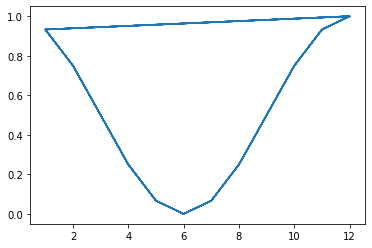

In [181]:
plt.plot(cal_df_parts_trans['month'], (((cal_df_parts_trans['month']).apply(lambda x: np.cos(x*2*np.pi/12)))+1)/2)

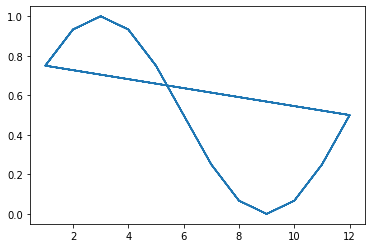

In [182]:
plt.plot(cal_df_parts_trans['month'], (((cal_df_parts_trans['month']).apply(lambda x: np.sin(x*2*np.pi/12)))+1)/2)

In [183]:
month_sine = (((cal_df_parts_trans['month']).apply(lambda x: np.sin(x*2*np.pi/12)))+1)/2
month_cosine = (((cal_df_parts_trans['month']).apply(lambda x: np.cos(x*2*np.pi/12)))+1)/2

In [184]:
cal_df_parts_trans['month_sine'] = month_sine
cal_df_parts_trans['month_cosine'] = month_cosine

In [185]:
cal_df_parts_trans

,wday_coded,snap_CA,Events,month,month_sine,month_cosine
day,,,,,,
1,1.0,0.0,0.0,1,0.750000,0.933013
2,1.0,0.0,0.0,1,0.750000,0.933013
3,0.0,0.0,0.0,1,0.750000,0.933013
4,0.0,1.0,0.0,2,0.933013,0.750000
5,0.0,1.0,0.0,2,0.933013,0.750000
...,...,...,...,...,...,...
1937,0.0,0.0,0.0,5,0.750000,0.066987
1938,0.0,0.0,0.0,5,0.750000,0.066987
1939,1.0,0.0,0.0,5,0.750000,0.066987


In [187]:
selling_prices_foods_1.transpose()

item_id,FOODS_1_001,FOODS_1_002,FOODS_1_003,FOODS_1_004,FOODS_1_005,FOODS_1_006,FOODS_1_008,FOODS_1_009,FOODS_1_010,FOODS_1_011,...,FOODS_1_210,FOODS_1_211,FOODS_1_212,FOODS_1_213,FOODS_1_214,FOODS_1_215,FOODS_1_216,FOODS_1_217,FOODS_1_218,FOODS_1_219
day,,,,,,,,,,,,,,,,,,,,,
d_1,6.00,0.00,0.00,0.00,8.82,0.00,0.0,0.00,0.00,4.56,...,0.00,0.0,0.00,4.76,0.00,0.00,0.00,11.76,10.00,12.00
d_2,0.00,7.88,0.00,0.00,26.46,0.00,0.0,0.00,0.00,2.28,...,0.00,0.0,0.00,0.00,0.00,0.00,5.14,14.70,3.00,10.00
d_3,0.00,0.00,0.00,0.00,8.82,5.91,0.0,0.00,0.00,0.00,...,0.00,0.0,0.00,2.38,0.00,0.00,5.14,2.94,4.00,10.00
d_4,2.00,7.88,0.00,0.00,8.82,1.97,0.0,0.00,0.00,0.00,...,0.00,0.0,0.00,2.38,0.00,0.00,0.00,8.82,0.00,8.00
d_5,8.00,7.88,2.88,0.00,0.00,13.79,0.0,0.00,0.00,0.00,...,0.00,0.0,0.00,2.38,0.00,0.00,0.00,0.00,0.00,6.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d_1937,0.00,9.48,0.00,3.92,0.00,7.44,0.0,0.00,0.00,0.00,...,5.88,0.0,0.00,0.00,3.14,3.68,0.00,10.62,14.70,4.48
d_1938,2.24,0.00,6.46,1.96,0.00,9.92,0.0,2.24,0.00,5.36,...,1.96,0.0,0.00,0.00,9.42,1.84,0.00,31.86,1.96,11.20
d_1939,0.00,9.48,6.46,1.96,0.00,0.00,0.0,0.00,11.28,0.00,...,7.84,0.0,5.98,0.00,0.00,0.00,0.00,21.24,2.94,8.96


In [188]:
cal_df_parts_trans_food_1 = cal_df_parts_trans.copy()

In [189]:
cal_df_parts_trans_food_1['selling_price'] = selling_prices_foods_1.transpose()['FOODS_1_001']

In [190]:
cal_df_parts_trans_food_1

,wday_coded,snap_CA,Events,month,month_sine,month_cosine,selling_price
day,,,,,,,
1,1.0,0.0,0.0,1,0.750000,0.933013,NaN
2,1.0,0.0,0.0,1,0.750000,0.933013,NaN
3,0.0,0.0,0.0,1,0.750000,0.933013,NaN
4,0.0,1.0,0.0,2,0.933013,0.750000,NaN
5,0.0,1.0,0.0,2,0.933013,0.750000,NaN
...,...,...,...,...,...,...,...
1937,0.0,0.0,0.0,5,0.750000,0.066987,NaN
1938,0.0,0.0,0.0,5,0.750000,0.066987,NaN
1939,1.0,0.0,0.0,5,0.750000,0.066987,NaN


In [191]:
selling_prices_foods_1_trans = selling_prices_foods_1.transpose()

In [195]:
selling_prices_foods_1_trans.index = cal_df_parts_trans_food_1.index

In [196]:
selling_prices_foods_1_trans

item_id,FOODS_1_001,FOODS_1_002,FOODS_1_003,FOODS_1_004,FOODS_1_005,FOODS_1_006,FOODS_1_008,FOODS_1_009,FOODS_1_010,FOODS_1_011,...,FOODS_1_210,FOODS_1_211,FOODS_1_212,FOODS_1_213,FOODS_1_214,FOODS_1_215,FOODS_1_216,FOODS_1_217,FOODS_1_218,FOODS_1_219
day,,,,,,,,,,,,,,,,,,,,,
1,6.00,0.00,0.00,0.00,8.82,0.00,0.0,0.00,0.00,4.56,...,0.00,0.0,0.00,4.76,0.00,0.00,0.00,11.76,10.00,12.00
2,0.00,7.88,0.00,0.00,26.46,0.00,0.0,0.00,0.00,2.28,...,0.00,0.0,0.00,0.00,0.00,0.00,5.14,14.70,3.00,10.00
3,0.00,0.00,0.00,0.00,8.82,5.91,0.0,0.00,0.00,0.00,...,0.00,0.0,0.00,2.38,0.00,0.00,5.14,2.94,4.00,10.00
4,2.00,7.88,0.00,0.00,8.82,1.97,0.0,0.00,0.00,0.00,...,0.00,0.0,0.00,2.38,0.00,0.00,0.00,8.82,0.00,8.00
5,8.00,7.88,2.88,0.00,0.00,13.79,0.0,0.00,0.00,0.00,...,0.00,0.0,0.00,2.38,0.00,0.00,0.00,0.00,0.00,6.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1937,0.00,9.48,0.00,3.92,0.00,7.44,0.0,0.00,0.00,0.00,...,5.88,0.0,0.00,0.00,3.14,3.68,0.00,10.62,14.70,4.48
1938,2.24,0.00,6.46,1.96,0.00,9.92,0.0,2.24,0.00,5.36,...,1.96,0.0,0.00,0.00,9.42,1.84,0.00,31.86,1.96,11.20
1939,0.00,9.48,6.46,1.96,0.00,0.00,0.0,0.00,11.28,0.00,...,7.84,0.0,5.98,0.00,0.00,0.00,0.00,21.24,2.94,8.96


In [200]:
cal_df_parts_trans_food_1['selling_price'] = selling_prices_foods_1_trans['FOODS_1_001']

In [201]:
cal_df_parts_trans_food_1

,wday_coded,snap_CA,Events,month,month_sine,month_cosine,selling_price
day,,,,,,,
1,1.0,0.0,0.0,1,0.750000,0.933013,6.00
2,1.0,0.0,0.0,1,0.750000,0.933013,0.00
3,0.0,0.0,0.0,1,0.750000,0.933013,0.00
4,0.0,1.0,0.0,2,0.933013,0.750000,2.00
5,0.0,1.0,0.0,2,0.933013,0.750000,8.00
...,...,...,...,...,...,...,...
1937,0.0,0.0,0.0,5,0.750000,0.066987,0.00
1938,0.0,0.0,0.0,5,0.750000,0.066987,2.24
1939,1.0,0.0,0.0,5,0.750000,0.066987,0.00


In [212]:
selling_prices_foods_1_trans['days'] = selling_prices_foods_1.transpose().index

In [213]:
selling_prices_foods_1_trans

item_id,FOODS_1_001,FOODS_1_002,FOODS_1_003,FOODS_1_004,FOODS_1_005,FOODS_1_006,FOODS_1_008,FOODS_1_009,FOODS_1_010,FOODS_1_011,...,FOODS_1_211,FOODS_1_212,FOODS_1_213,FOODS_1_214,FOODS_1_215,FOODS_1_216,FOODS_1_217,FOODS_1_218,FOODS_1_219,days
days,,,,,,,,,,,,,,,,,,,,,
d_1,6.00,0.00,0.00,0.00,8.82,0.00,0.0,0.00,0.00,4.56,...,0.0,0.00,4.76,0.00,0.00,0.00,11.76,10.00,12.00,d_1
d_2,0.00,7.88,0.00,0.00,26.46,0.00,0.0,0.00,0.00,2.28,...,0.0,0.00,0.00,0.00,0.00,5.14,14.70,3.00,10.00,d_2
d_3,0.00,0.00,0.00,0.00,8.82,5.91,0.0,0.00,0.00,0.00,...,0.0,0.00,2.38,0.00,0.00,5.14,2.94,4.00,10.00,d_3
d_4,2.00,7.88,0.00,0.00,8.82,1.97,0.0,0.00,0.00,0.00,...,0.0,0.00,2.38,0.00,0.00,0.00,8.82,0.00,8.00,d_4
d_5,8.00,7.88,2.88,0.00,0.00,13.79,0.0,0.00,0.00,0.00,...,0.0,0.00,2.38,0.00,0.00,0.00,0.00,0.00,6.00,d_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d_1937,0.00,9.48,0.00,3.92,0.00,7.44,0.0,0.00,0.00,0.00,...,0.0,0.00,0.00,3.14,3.68,0.00,10.62,14.70,4.48,d_1937
d_1938,2.24,0.00,6.46,1.96,0.00,9.92,0.0,2.24,0.00,5.36,...,0.0,0.00,0.00,9.42,1.84,0.00,31.86,1.96,11.20,d_1938
d_1939,0.00,9.48,6.46,1.96,0.00,0.00,0.0,0.00,11.28,0.00,...,0.0,5.98,0.00,0.00,0.00,0.00,21.24,2.94,8.96,d_1939


In [214]:
selling_prices_foods_1_trans['days'] = selling_prices_foods_1_trans['days'].apply(lambda x: int(x.split('_')[1]))

In [215]:
selling_prices_foods_1_trans.set_index('days', inplace=True)

In [216]:
selling_prices_foods_1_trans

item_id,FOODS_1_001,FOODS_1_002,FOODS_1_003,FOODS_1_004,FOODS_1_005,FOODS_1_006,FOODS_1_008,FOODS_1_009,FOODS_1_010,FOODS_1_011,...,FOODS_1_210,FOODS_1_211,FOODS_1_212,FOODS_1_213,FOODS_1_214,FOODS_1_215,FOODS_1_216,FOODS_1_217,FOODS_1_218,FOODS_1_219
days,,,,,,,,,,,,,,,,,,,,,
1,6.00,0.00,0.00,0.00,8.82,0.00,0.0,0.00,0.00,4.56,...,0.00,0.0,0.00,4.76,0.00,0.00,0.00,11.76,10.00,12.00
2,0.00,7.88,0.00,0.00,26.46,0.00,0.0,0.00,0.00,2.28,...,0.00,0.0,0.00,0.00,0.00,0.00,5.14,14.70,3.00,10.00
3,0.00,0.00,0.00,0.00,8.82,5.91,0.0,0.00,0.00,0.00,...,0.00,0.0,0.00,2.38,0.00,0.00,5.14,2.94,4.00,10.00
4,2.00,7.88,0.00,0.00,8.82,1.97,0.0,0.00,0.00,0.00,...,0.00,0.0,0.00,2.38,0.00,0.00,0.00,8.82,0.00,8.00
5,8.00,7.88,2.88,0.00,0.00,13.79,0.0,0.00,0.00,0.00,...,0.00,0.0,0.00,2.38,0.00,0.00,0.00,0.00,0.00,6.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1937,0.00,9.48,0.00,3.92,0.00,7.44,0.0,0.00,0.00,0.00,...,5.88,0.0,0.00,0.00,3.14,3.68,0.00,10.62,14.70,4.48
1938,2.24,0.00,6.46,1.96,0.00,9.92,0.0,2.24,0.00,5.36,...,1.96,0.0,0.00,0.00,9.42,1.84,0.00,31.86,1.96,11.20
1939,0.00,9.48,6.46,1.96,0.00,0.00,0.0,0.00,11.28,0.00,...,7.84,0.0,5.98,0.00,0.00,0.00,0.00,21.24,2.94,8.96


In [217]:
cal_df_parts_trans_food_1['selling_price'] = selling_prices_foods_1_trans['FOODS_1_001']

In [218]:
cal_df_parts_trans_food_1

,wday_coded,snap_CA,Events,month,month_sine,month_cosine,selling_price
day,,,,,,,
1,1.0,0.0,0.0,1,0.750000,0.933013,6.00
2,1.0,0.0,0.0,1,0.750000,0.933013,0.00
3,0.0,0.0,0.0,1,0.750000,0.933013,0.00
4,0.0,1.0,0.0,2,0.933013,0.750000,2.00
5,0.0,1.0,0.0,2,0.933013,0.750000,8.00
...,...,...,...,...,...,...,...
1937,0.0,0.0,0.0,5,0.750000,0.066987,0.00
1938,0.0,0.0,0.0,5,0.750000,0.066987,2.24
1939,1.0,0.0,0.0,5,0.750000,0.066987,0.00


Next steps:

- The above 1941 rows of data should be copied multiple times, with each instance, the selling price of one more food item is created. In all, we will have 1941x216 data points


# Change Log
11 February 2021